Model accuracy: 0.7991


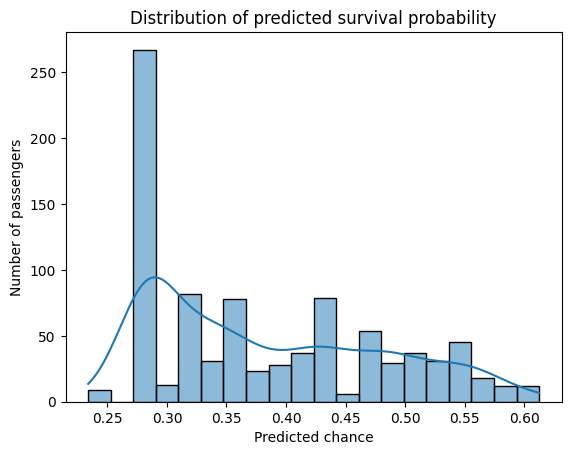

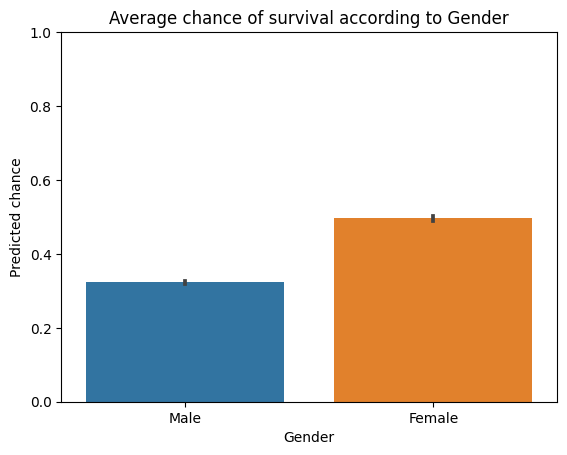

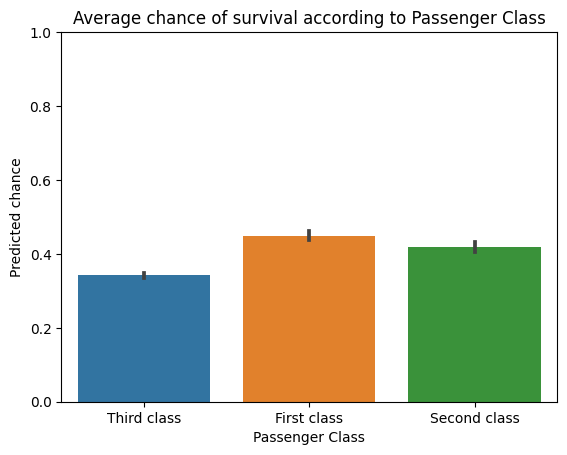

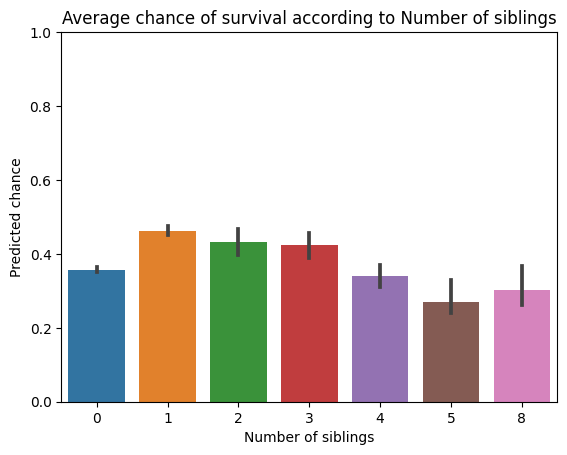

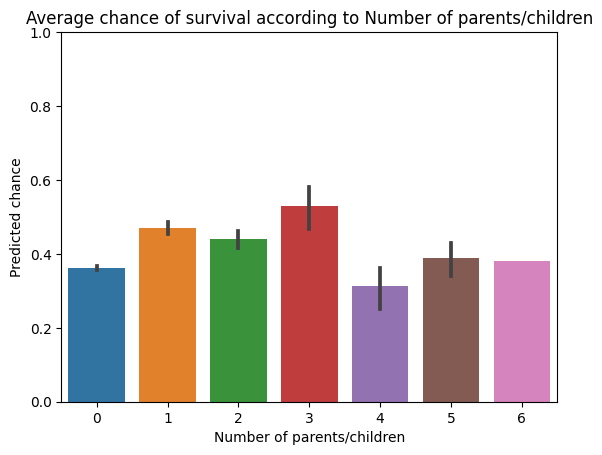

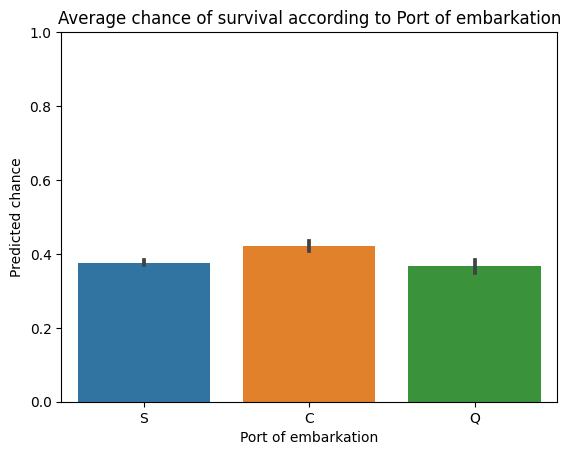

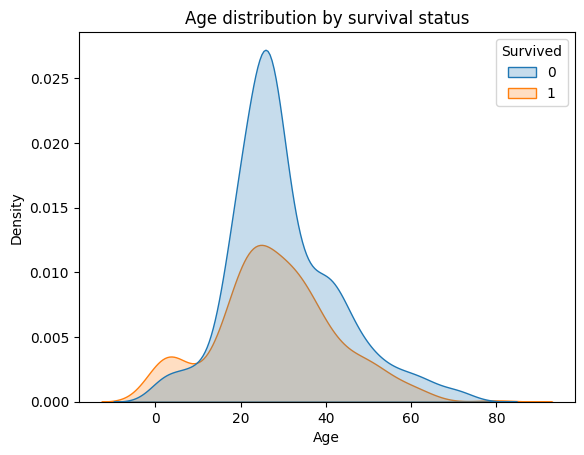

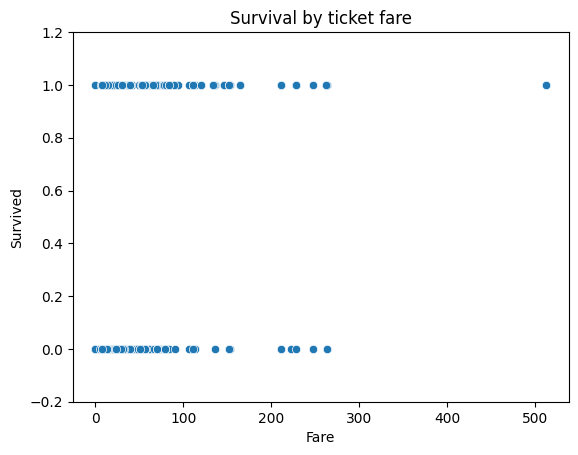

In [59]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

def load_and_prepare_data(path):
    data = pd.read_csv(path)

    #fill the missing age by average based on the passenger class and gender
    data['Age'] = data['Age'].fillna(data.groupby(['Sex', 'Pclass'])['Age'].transform('mean'))

    #fill the rest of the missing data
    data['Cabin'] = data['Cabin'].fillna('Unknown')
    data['Embarked'] = data['Embarked'].fillna('Unknown')

    #replace names to preffered format
    data['Pclass'] = data['Pclass'].replace({
        1: 'First class',
        2: 'Second class',
        3: 'Third class'
    })

    data['Sex'] = data['Sex'].replace({
        'male': 'Male',
        'female': 'Female'
    })
    return data

def calculate_weights(data):
    """Calculates weights of certain feature based on the survival rate difference between smallest and largest group"""
    data_filtered = data[data['Embarked'] != 'Unknown']
    diffs = {
        'Sex': data.groupby('Sex')['Survived'].mean().max() - data.groupby('Sex')['Survived'].mean().min(),
        'Pclass' : data.groupby('Pclass')['Survived'].mean().max() - data.groupby('Pclass')['Survived'].mean().min(),
        'SibSp' : data.groupby('SibSp')['Survived'].mean().max() - data.groupby('SibSp')['Survived'].mean().min(),
        'Parch' : data.groupby('Parch')['Survived'].mean().max() - data.groupby('Parch')['Survived'].mean().min(),
    }
    total = sum(diffs.values())
    return {k : v / total for k, v in diffs.items()}

def convert_probs_to_dict(data):
    data_filtered = data[data['Embarked'] != 'Unknown']
    return {
        'Sex': data.groupby('Sex')['Survived'].mean().to_dict(),
        'Pclass': data.groupby('Pclass')['Survived'].mean().to_dict(),
        'SibSp': data.groupby('SibSp')['Survived'].mean().to_dict(),
        'Parch': data.groupby('Parch')['Survived'].mean().to_dict(),
    }

def weighted_feature_score(row, probs, weights):
    return (
        probs['Sex'].get(row['Sex'], 0.5) * weights['Sex'] +
        probs['Pclass'].get(row['Pclass'], 0.5) * weights['Pclass'] +
        probs['SibSp'].get(row['SibSp'], 0.5) * weights['SibSp'] + 
        probs['Parch'].get(row['Parch'], 0.5) * weights['Parch']
    )

def add_survival_predictions(data, probs, weights):
    data['PredictedChance'] = data.apply(
        lambda row: weighted_feature_score(row, probs, weights), axis = 1)
    return data

def find_best_threshold(data):
    best_accuracy = 0
    best_threshold = 0.5
    for threshold in np.arange(0.3, 0.7, 0.01):
        predictions = (data['PredictedChance'] >= threshold).astype('int')
        accuracy = (predictions == data['Survived']).mean()
        if accuracy > best_accuracy:
            best_accuracy = accuracy
            best_threshold = threshold
    return best_threshold

def train_model(data):
    probs = convert_probs_to_dict(data)
    weights = calculate_weights(data)
    data = add_survival_predictions(data, probs, weights)
    threshold = find_best_threshold(data)
    return probs, weights, threshold, data

def predict_test(data, probs, weights, threshold):
    test = add_survival_predictions(data, probs, weights)
    test['Survived'] = (test['PredictedChance'] >= threshold).astype('int')
    return test[['PassengerId', 'Survived']]

def evaluate_predictions(data, threshold):
    predictions = (data['PredictedChance'] >= threshold).astype(int)
    actual = data['Survived']
    correct = (predictions == actual).sum()
    total = len(actual)
    accuracy = correct / total
    print(f"Model accuracy: {accuracy:.4f}")

def plot_predicted_chance(data):
    sns.histplot(data['PredictedChance'], bins = 20, kde = True)
    plt.title("Distribution of predicted survival probability")
    plt.xlabel("Predicted chance")
    plt.ylabel("Number of passengers")
    plt.show()

def plot_feature_vs_prediction(data, column):
    LABEL_MAPS = {
        'Sex': 'Gender',
        'Pclass': 'Passenger Class',
        'SibSp': 'Number of siblings',
        'Parch': 'Number of parents/children',
        'Embarked': 'Port of embarkation'
    }
    if 'Unknown' in data[column].unique():
        data = data[data[column] != 'Unknown']
    sns.barplot(data = data, x = column, y = 'PredictedChance')
    plt.title(f"Average chance of survival according to {LABEL_MAPS[column]}")
    plt.ylim(0, 1)
    plt.xlabel(LABEL_MAPS[column])
    plt.ylabel("Predicted chance")
    plt.show()

def plot_age_distribution(data):
    sns.kdeplot(data=data, x = 'Age', hue = 'Survived', fill = True)
    plt.title("Age distribution by survival status")
    plt.xlabel("Age")
    plt.ylabel("Density")
    plt.show()

def plot_fare_vs_survival(data):
    sns.scatterplot(data = data, x = 'Fare', y = 'Survived')
    plt.title("Survival by ticket fare")
    plt.xlabel("Fare")
    plt.ylabel("Survived")
    plt.ylim(-0.2, 1.2)
    plt.show()

def main():

    #load database
    train = load_and_prepare_data('/kaggle/input/titanic/train.csv')
    test = load_and_prepare_data('/kaggle/input/titanic/test.csv')

    probs, weights, threshold, train = train_model(train)

    submission = predict_test(test, probs, weights, threshold)

    # Export predicted survival results for test set
    submission.to_csv('submission.csv', index = False)

    #show training prediction accuracy
    evaluate_predictions(train, threshold)

    #few examples of informative charts
    plot_predicted_chance(train)
    plot_feature_vs_prediction(train, 'Sex')
    plot_feature_vs_prediction(train, 'Pclass')
    plot_feature_vs_prediction(train, 'SibSp')
    plot_feature_vs_prediction(train, 'Parch')
    plot_feature_vs_prediction(train, 'Embarked')
    plot_age_distribution(train)
    plot_fare_vs_survival(train)

main()
    